#Part1: Importing Fashion-MNIST Dadat set and preprocessing the dataset

The architecture of our model is inspired by Jason Brownlee's architecture presented on  [the machine learning mastery website.](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/)



In [61]:
try: 
    #print tensorflew version only exists in colab
    %tensorflow_version 2.x
    
except Exception:
    print('Does not exist tensorflow version 2 or exists an older version')


In [62]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
SavDir = '/content/drive/MyDrive/SavedModel/'
!cd '/content/drive/MyDrive/SavedModel/'

## inastall keras tuner for part 5

In [ ]:
!pip install keras-tuner

## import Libaray

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D,BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, CallbackList
from tensorflow.keras.datasets import  *
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras import backend as k
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix 
import itertools
import kerastuner

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import random
import os
# import autotime
# %load_ext autotime



## Deleting directory content

In [66]:
def RemoveFile(Dir,FileName):
    if (FileName in os.listdir(Dir)):
        os.remove(Dir+FileName)
    

##Import And Flatten DataSet



ImportDataSet Function loads and normalizes the data set

In [67]:
def ImportDataSet(DataSet):

    (train_images, trian_labels), (test_images, test_labels) = DataSet.load_data()
    

    # Normalize DataSet
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    train_images = train_images/255.0
    test_images = test_images/255.0

    #reshape images 
    train_images_F =np.reshape(train_images,(train_images.shape[0],28,28,1))
    test_images_F = np.reshape(test_images,(test_images.shape[0],28,28,1))

    #One hot encoding
    encode_trian_labels = to_categorical(trian_labels)
    encode_test_labels = to_categorical(test_labels)

    return (train_images_F,encode_trian_labels),(test_images_F,encode_test_labels)


this function uses np.reshape function for transforming the training images form (-1,28,28) into (-1,28*28).

In [68]:
def Flat_ten():
    #Flatten DataSet
    train_images_F =np.reshape(train_images,(-1,28*28))
    test_images_F = np.reshape(test_images,(-1,28*28))
    return train_images_F, test_images_F

In [69]:
# Loading and normalizing the fashion MNIST dataset
(train_images, trian_labels), (test_images, test_labels) = ImportDataSet(fashion_mnist)

print("shape of training data:",train_images.shape )
print("shape of test data:",test_images.shape )
print("shape of encoded training labels:",trian_labels.shape )
print("shape of encoded test labels:",test_labels.shape )

shape of training data: (60000, 28, 28, 1)
shape of test data: (10000, 28, 28, 1)
shape of encoded training labels: (60000, 10)
shape of encoded test labels: (10000, 10)
shape of training data: (60000, 28, 28, 1)
shape of test data: (10000, 28, 28, 1)
shape of encoded training labels: (60000, 10)
shape of encoded test labels: (10000, 10)


##Plot random images

The following function for the positive integer n firstly selects n $\times$ n images at random and then plots them.



In [70]:
def Image_show(n,images):
    #Visualize n**2 fig 
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True,
                            sharey=True, figsize=(5, 5))
    x=np.reshape(images,(-1,28,28))
    man_index = x.shape[0]
    index = np.random.randint(0,man_index,size=n*n)

    for indx, im in enumerate(index):
        ax = axs[indx // n, indx % n]
        ax.imshow(x[im, :, :],cmap = 'binary')
        #plt.cm.BrBG_r 
        ax.axis('off')
    

    plt.tight_layout()
    plt.show()
    

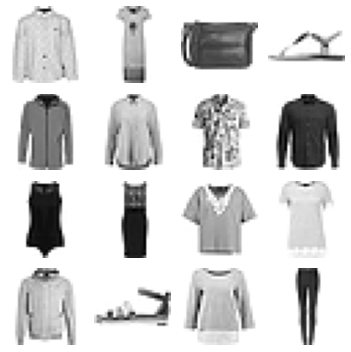

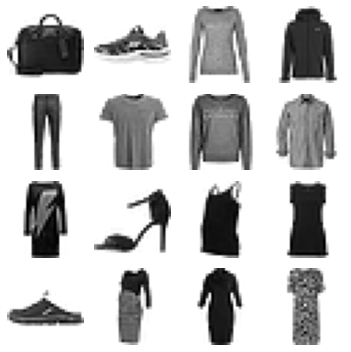

In [71]:
Image_show(4,train_images)

#Part2: Baseline Convolutional Neural Network

In [72]:
def BCNN():
    input = Input(shape=(28,28,1),name='base_input')

    ############################ 1th convolutional layer  #####################
    Conv_layer1 = Conv2D(32,3,strides=(1,1),activation='relu',
                         padding='valid',kernel_initializer='he_uniform',
                         name='First_Convelutional_Layer')(input)

    MaxPoolLayer1 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='valid',name='1_Poolling_Layer')(Conv_layer1)

    
    ############################# Fully Conected Layers  #######################
    FlattenLayer1= Flatten(name='Flatten_layer')(MaxPoolLayer1)
    
    Dense1 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC1')(FlattenLayer1)
    
    OutPut= Dense(10,activation='softmax', name='OutPut')(Dense1)
    #############################       Model       #############################
    model = Model(inputs=input,outputs=OutPut)

    

    return model

## Model Summary

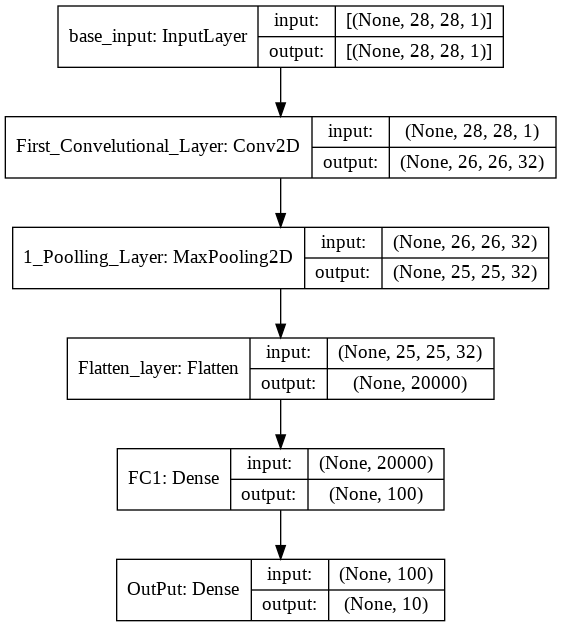

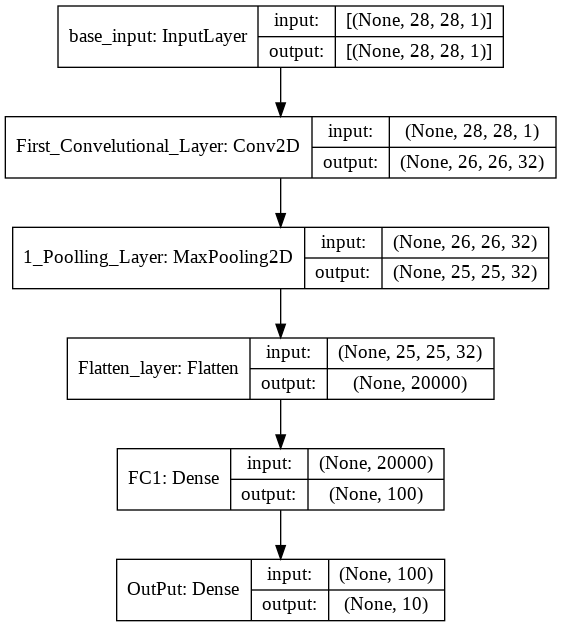

In [73]:
model= BCNN()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [74]:
# (train_images, trian_labels), (test_images, test_labels) = fashion_mnist.load_data()

# # Normalize DataSet
# train_images = train_images.astype('float32')
# test_images = test_images.astype('float32')

# train_images = train_images/255-0.5
# test_images = test_images/255-0.5


# #One hot encoding
# encode_trian_labels = to_categorical(trian_labels)
# encode_test_labels = to_categorical(test_labels)

In [75]:
sgd = SGD(learning_rate=0.01,momentum=0.9)

model.compile(loss='CategoricalCrossentropy',optimizer=sgd,
            metrics=[
                    
                    'accuracy',
                    'MSE'
            ])
history = model.fit(train_images,trian_labels,
                    epochs=10, batch_size=32,
                    validation_data=(test_images,test_labels)
                    )

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.6432 - accuracy: 0.7827 - MSE: 0.0299 - val_loss: 0.3464 - val_accuracy: 0.8766 - val_MSE: 0.0178
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2978 - accuracy: 0.8919 - MSE: 0.0155 - val_loss: 0.2985 - val_accuracy: 0.8933 - val_MSE: 0.0154
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2421 - accuracy: 0.9100 - MSE: 0.0129 - val_loss: 0.2902 - val_accuracy: 0.8970 - val_MSE: 0.0150
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2102 - accuracy: 0.9204 - MSE: 0.0113 - val_loss: 0.2892 - val_accuracy: 0.9008 - val_MSE: 0.0146
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1895 - accuracy: 0.9284 - MSE: 0.0102 - val_loss: 0.2813 - val_accuracy: 0.9027 - val_MSE: 0.0142
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1715 - accuracy: 0.9359 - MSE: 0.0093 - va

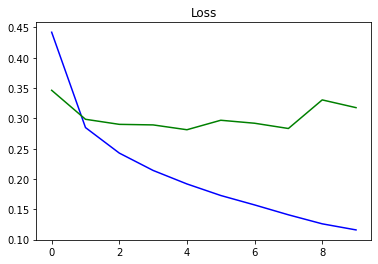

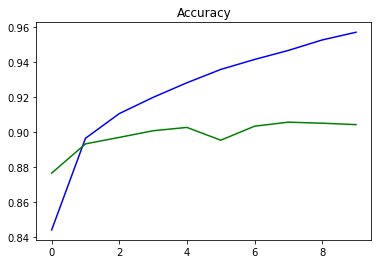

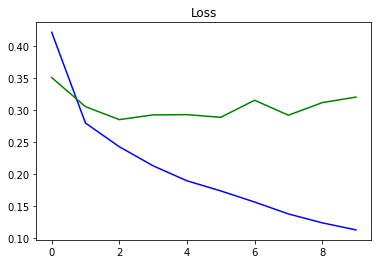

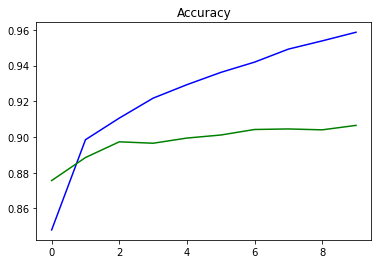

In [76]:
def plot_metrics(metric_name,title,ymin=0,ylim=5):
    plt.title(title)
    #plt.ylim(ymin,ylim)
    plt.plot(history.history[metric_name],color='blue', label=metric_name)
    plt.plot(history.history['val_'+metric_name],color='green',label='val_'+metric_name)
    plt.show()


plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

# Evalute model using K-fold Cross validation

For improving preformance of our model we use K-fold cross validtion. Each test set will be 20% of training data set, or about 12000 examples. 

<center>
<img src="https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png" alt="K-Fold Cross Validation" class="center">
</center>


In [77]:
# Auxiliary function for getting model name in each of the k iterations
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [78]:
def Model_Evalution(trainData, TrainLabels, ModelName=BCNN,K_Fold=5,epoch=50, batch_size=100):

    Scores, histories,MSES =list(), list(),list()
    Validation_Loss = list()

    # Prepare Cross Validation
    kfold = KFold(n_splits=K_Fold,shuffle=True,random_state=1)

    #Enumerate Splits
    fold_var = 1
    for train_index, val_index in kfold.split(trainData):

        # Creat Validarion and Training set 
        RemoveFile(SavDir,get_model_name(fold_var))

        TrgSet, TrLabels = trainData[train_index], TrainLabels[train_index]
        ValSet, ValLabels = trainData[val_index], TrainLabels[val_index]

        #Creat New Model

        model = ModelName()
        sgd = SGD(learning_rate=0.01,momentum=0.9)

        model.compile(loss='CategoricalCrossentropy',optimizer=sgd,
                metrics=[
                        
                        'accuracy',
                        'MSE'
                ])
        # Creat Callbacks 
        CheckPoint = ModelCheckpoint(SavDir+get_model_name(fold_var),
                                               monitor='val_accuracy',
                                               verbose=0,
                                               save_best_only=True, mode='max')
        
        callbacks_list = [CheckPoint]
        # This saves the best model
	    # FIT THE MODEL
        history = model.fit(TrgSet, TrLabels,
                            epochs=epoch, batch_size=batch_size,verbose=0,
                            validation_data=(ValSet, ValLabels ),
                            callbacks=callbacks_list,
                            )
        
        
        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights(SavDir+get_model_name(fold_var))
        
        results = model.evaluate(ValSet, ValLabels,verbose=1)
        results = dict(zip(model.metrics_names,results))
        
        Scores.append(results['accuracy'])
        Validation_Loss.append(results['loss'])
        histories.append(history)
        
        #k.clear_session()
        
        fold_var += 1
        

    return Scores, histories,Validation_Loss

##Evalute Baseline model using k_fold Cross validation

the following results show that using k-fold cross-validation leads to better accuracy.

In [19]:
scores, history,Validation_Loss = Model_Evalution(train_images,trian_labels,K_Fold=5,epoch=10, batch_size=32)

375/375 [==============================] - 1s 2ms/step - loss: 0.2741 - accuracy: 0.9133 - MSE: 0.0132


## return the best model

During training our models using K-Fold Cross-validation we save the best model for each fold. the following function returns the name of the best model among these models.

In [20]:
def Best_Model(scores):

    MaxAcc = np.where(scores==np.max(scores))[0][0]
    return MaxAcc+1 , get_model_name(MaxAcc+1)

In [21]:
fold, bestmodel=Best_Model(scores)

## Plot Loss and Accuracy graph

In [22]:
def plot_metrics(metric_name,title,ymin=0,ylim=5):
    
    plt.title(title)
    #plt.ylim(ymin,ylim)
    for i in range(len(history)):
        plt.plot(history[i].history[metric_name],color='blue', label=metric_name)
        plt.plot(history[i].history['val_'+metric_name],color='green',label='val_'+metric_name)
    plt.show()


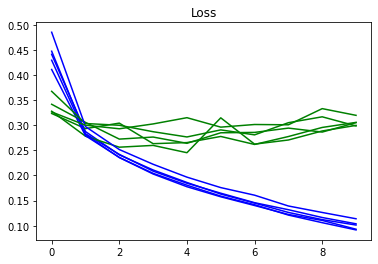

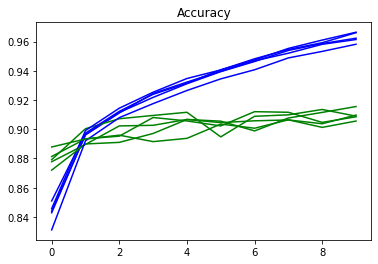

In [23]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

##Loading the saved model and measuring the model generalization power

In [24]:
def MGP(test_images, test_labels,K_Fold=5):
    '''
    This Function firstly loads the model associated to last fold and then evaluates its performance
    '''

    model = load_model(SavDir+get_model_name(K_Fold))
    #model.load_weights(SavDir+get_model_name(K_Fold))
        
    results = model.evaluate(test_images, test_labels,verbose=1)
    # results = dict(zip(model.metrics_names,results))
    
    return results

PERF=MGP(test_images, test_labels,K_Fold=fold)   

313/313 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.9120 - MSE: 0.0140


##Plot Confusion Matrix

In [25]:
def PredLabels(test_images, test_labels,K_Fold=5):
    model.load_weights(SavDir+get_model_name(K_Fold))
    #predict labels for test set
    Predictions = model.predict(test_images) 
    Predictions =np.argmax(Predictions, axis=1) 
    Labels = np.argmax(test_labels, axis=1)
    return Predictions, Labels

In [26]:
def ConfusionMatrix(test_images, test_labels,K_Fold=5):
    

    Predictions, Labels=PredLabels(test_images, test_labels,K_Fold)
    
    #CalCulate Confusion Matrix
    ConMat = confusion_matrix(Labels, Predictions)
    
    return ConMat

a useful link for the  confusion-matrix

https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

In [27]:
class_names=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
ConfusionMatrix(test_images, test_labels, K_Fold=fold)


array([[875,   0,  23,  18,   2,   3,  71,   0,   8,   0],
       [  0, 979,   0,  16,   1,   0,   3,   0,   1,   0],
       [ 15,   1, 850,   7,  42,   0,  84,   0,   1,   0],
       [  9,   2,  15, 912,  18,   2,  33,   0,   9,   0],
       [  0,   1,  75,  20, 817,   1,  86,   0,   0,   0],
       [  0,   0,   0,   0,   0, 986,   0,   5,   0,   9],
       [104,   1,  40,  22,  35,   0, 787,   0,  11,   0],
       [  0,   0,   0,   0,   0,  10,   0, 968,   1,  21],
       [  1,   1,   1,   5,   0,   1,   7,   3, 981,   0],
       [  0,   0,   0,   0,   0,   5,   0,  29,   1, 965]])

In [28]:
def plot_confusion_matrix(test_images, test_labels,class_names,K_Fold=5):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    cm = ConfusionMatrix(test_images, test_labels,K_Fold)
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

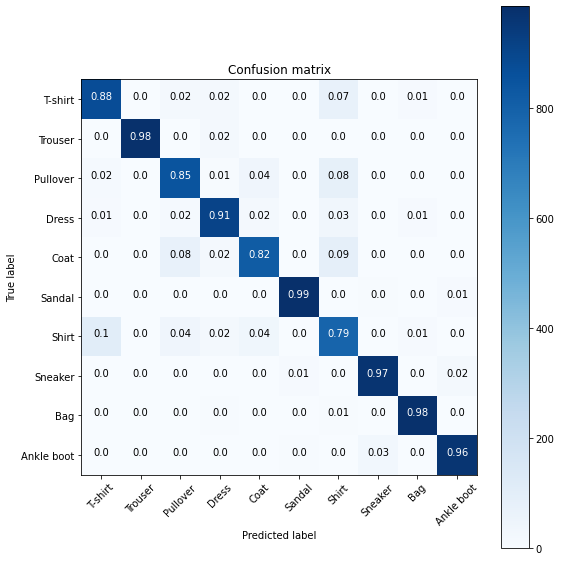

In [29]:
plot_confusion_matrix(test_images, test_labels,class_names,K_Fold=fold)

##summarize model performance

the following function calculates the summary of the model performance.

Accuracy: mean=91.142 std=0.314, n=5


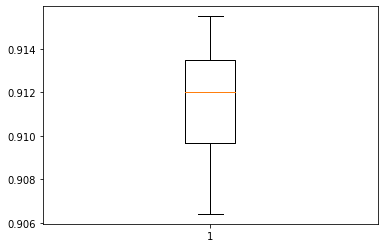

In [30]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100,
                                               np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores,notch=False)
	plt.show()
 
summarize_performance(scores)

#Part 4: effect of adding more convolutional layers and using regularization on the performance of model

in this part, we are going to show the effect of using more convolutional layers, different padding, and embedding dropout and batch normalization layers on improving the performance of the model.

## increasing convolutional layers, numbers of filter, and changing the padding 


*   padding 
<center>
<img src="https://miro.medium.com/max/700/1*Tq_lyA2uRy4BTBpYlbKTTQ.gif" alt="Padding" class="center">
</center>




*   In the first example in the above picture, there is no padding which is called Valid padding. when valid padding has used the size of the output image is downsized.
*   In the third example in the above picture, there is one layer padding (half of the size of filter) with blank pixels. in this case, the output has the same size as the input image so it is called the same or half padding.  










In [31]:
def Modified_Padding_BCNN():
    input = Input(shape=(28,28,1),name='base_input')
    ###################################### 1th convolational layer ##################################
    Conv_layer1 = Conv2D(32,3,strides=(1,1),activation='relu',
                         padding='same',kernel_initializer='he_uniform',
                         name='First_Convelutional_Layer')(input)

    MaxPoolLayer1 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='valid',
                              name='1_Poolling_Layer')(Conv_layer1)

    ###################################### Fully Conected Layers ##################################

    FlattenLayer1= Flatten(name='Flatten_layer')(MaxPoolLayer1)
    
    Dense1 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC1')(FlattenLayer1)
   
    OutPut= Dense(10,activation='softmax', name='OutPut')(Dense1)
    ######################################          Model      ##################################
    model = Model(inputs=input,outputs=OutPut)

    

    return model

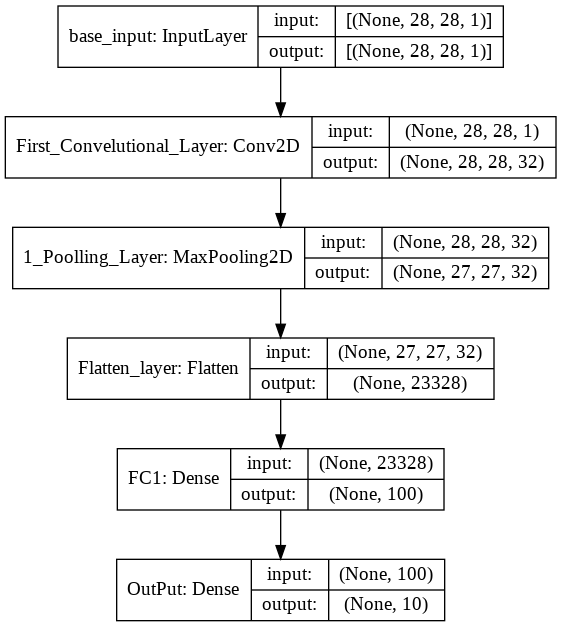

In [32]:
model= Modified_Padding_BCNN()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [33]:
scores, history,Validation_Loss =Model_Evalution(train_images,trian_labels, 
                                                 ModelName=Modified_Padding_BCNN, K_Fold=5,epoch=10, batch_size=32)

375/375 [==============================] - 1s 2ms/step - loss: 0.2965 - accuracy: 0.9074 - MSE: 0.0140


## Model Evalution

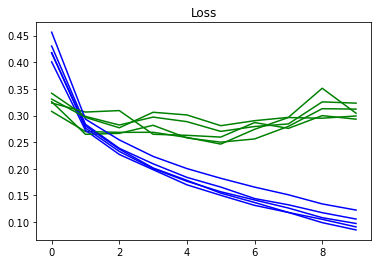

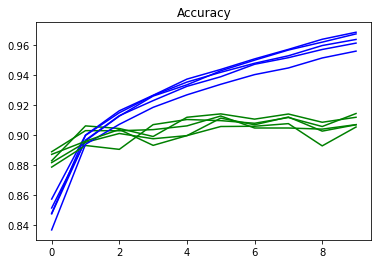

In [34]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

In [35]:
fold, bestmodel=Best_Model(scores)
PerMBCNN=MGP(test_images, test_labels,K_Fold=fold) 

313/313 [==============================] - 1s 3ms/step - loss: 0.3277 - accuracy: 0.9064 - MSE: 0.0144


___
<h1 style="color:#FF0000;">
Conculsion
</h1>

```
The above results show that changing padding patterns improves the performance of the model.
```
___

## increasing the number of layers and filters



```
in this part, the effect of increasing the number of convolutional layers and filters on the performance of the model has been investigated.
```



In [36]:
def DeepModified_Padding_BCNN():
    input = Input(shape=(28,28,1),name='base_input')
    ###################################### 1th convolational layer ##################################
    Conv_layer1 = Conv2D(64,3,strides=(1,1),
                         activation='relu',padding='same',
                         kernel_initializer='he_uniform',
                         name='First_Convelutional_Layer')(input)

    MaxPoolLayer1 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='1_Poolling_Layer')(Conv_layer1)
    ###################################### 2th convolational layer ##################################

    Conv_layer2 = Conv2D(64,3,strides=(1,1),activation='relu',
                         padding='same',
                         name='2_Convelutional_Layer')(MaxPoolLayer1)
                         
    MaxPoolLayer2 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='2_Poolling_Layer')(Conv_layer2)
    ###################################### 3th convolational layer ##################################

    Conv_layer3 = Conv2D(64,3,strides=(1,1),activation='relu',
                         padding='same',
                         name='3_Convelutional_Layer')(MaxPoolLayer2)

    MaxPoolLayer3 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='valid',
                              name='3_Poolling_Layer')(Conv_layer3)
    ###################################### Fully concted layers ##################################

    FlattenLayer1= Flatten(name='Flatten_layer')(MaxPoolLayer3)
    
    Dense1 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC1')(FlattenLayer1)
    
    Dense2 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC2')(Dense1)

    OutPut= Dense(10,activation='softmax', name='OutPut')(Dense2)
    ###################################     Model   ###############################################

    model = Model(inputs=input,outputs=OutPut)

    

    return model

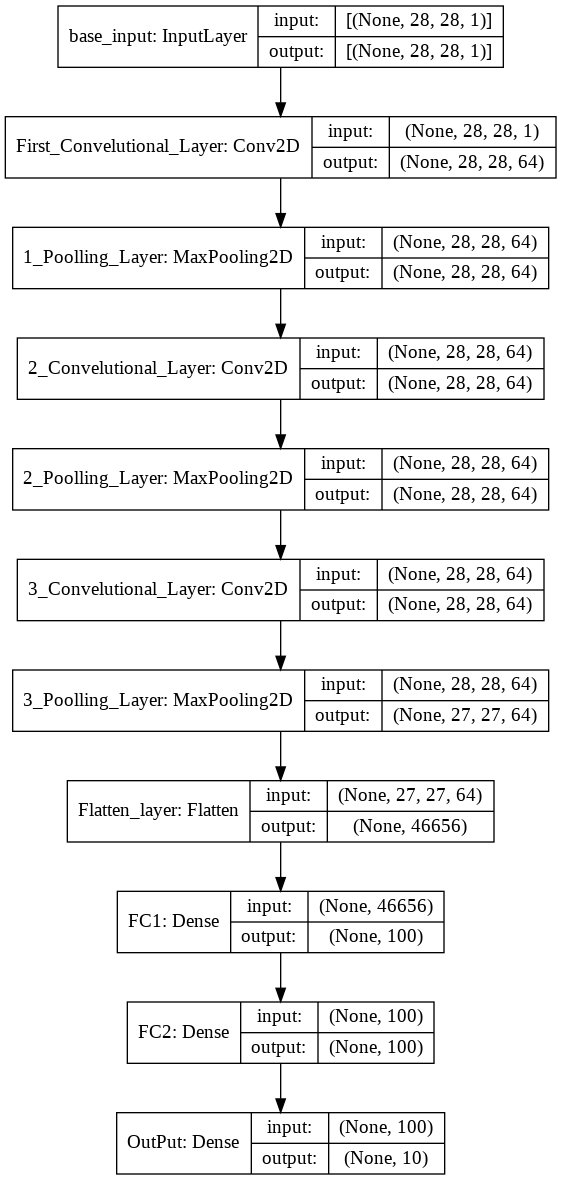

In [37]:
model= DeepModified_Padding_BCNN()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [38]:
scores, history,Validation_Loss =Model_Evalution(train_images,trian_labels, 
                                                 ModelName=DeepModified_Padding_BCNN, K_Fold=5,epoch=10, batch_size=32)

375/375 [==============================] - 1s 3ms/step - loss: 0.2695 - accuracy: 0.9147 - MSE: 0.0129


## Model Evalution

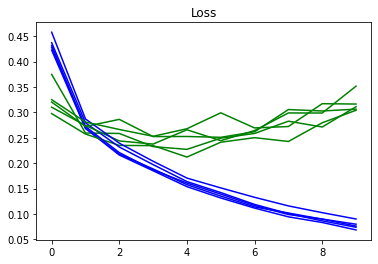

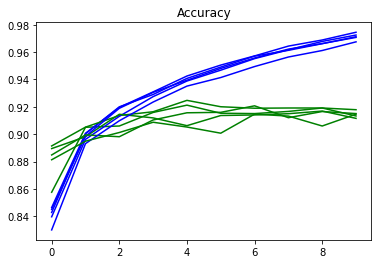

In [39]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

In [40]:
fold, bestmodel=Best_Model(scores)
PerMBCNN=MGP(test_images, test_labels,K_Fold=fold) 

313/313 [==============================] - 1s 4ms/step - loss: 0.2383 - accuracy: 0.9182 - MSE: 0.0122


<hr>
<h1> Conclusion </h1>



```
the above results show a slight improvement in the performance of the baseline convolutional neural network.
```
<hr>

## Adding dropout and batchnormalization layers. 

<dl>
    <dt> <b>dropout:</b> </dt>
    <dd> 
    <p align='justify'>
    Dropout deactivates the neurons randomly at each training step instead of training the data on the original network, we train the data on the network with dropped out nodes. In the next iteration of the training step, the hidden neurons which are deactivated by dropout changes because of its probabilistic behavior. In this way, by applying dropout i.e…deactivating certain individual nodes at random during training we can simulate an ensemble of neural network with different architectures. 
    </p>
    <center>
<img src="https://s17.picofile.com/file/8429822192/a86utxY.gif" alt="Padding" class="center">
    </center> </dd>
    <dt> <b>Batchnormalization:</b> </dt>
    <dd>
        <p align='justify'>
        Batch normalization is a method used to make artificial neural networks faster and more stable through the normalization of the input hidden layers by re-centering and re-scaling. 
        </p>
        <center>
        <img  src='https://kharshit.github.io/img/batch_normalization.png' alt="Batch Normalization">
        </center>
    </dd>

</dl>




## Using Batch Normalization Layer

In [41]:
def regularized_BCNN():
    input = Input(shape=(28,28,1),name='base_input')

    ################################### 1th convoltional layer##################################
    Conv_layer1 = Conv2D(32,3,strides=(1,1),padding='same',
                         kernel_initializer='he_uniform',
                         name='First_Convelutional_Layer')(input)

    BN1 = BatchNormalization(name='1_BN')(Conv_layer1)

    ActLayer = Activation('relu', name='activation_layer')(BN1)

    MaxPoolLayer1 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='valid',
                              name='1_Poolling_Layer')(ActLayer)

    ############################### 2th convolutional layer######################################
    Conv_layer2 = Conv2D(64,3,strides=(1,1),padding='same',
                         name='2_Convelutional_Layer')(MaxPoolLayer1)
    BN2 = BatchNormalization(name='2_BN')(Conv_layer2)

    ActLayer2 = Activation('relu', name='2_activation_layer')(BN2)

    MaxPoolLayer2 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='2_Poolling_Layer')(ActLayer2)

    ############################### 3th convolutional layer######################################
    Conv_layer3 = Conv2D(64,3,strides=(1,1),
                         padding='valid',
                         name='3_Convelutional_Layer')(MaxPoolLayer2)

    BN3 = BatchNormalization(name='3_BN')(Conv_layer3)

    ActLayer3 = Activation('relu', name='3_activation_layer')(BN3)

    MaxPoolLayer3 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='valid',
                              name='3_Poolling_Layer')(ActLayer3)
    ###############################  Fully Conceted Layers ######################################
    FlattenLayer1= Flatten(name='Flatten_layer')(MaxPoolLayer3)
    
    Dense1 =Dense(100,kernel_initializer='he_uniform',
                  name='FC1')(FlattenLayer1)

    BN4 = BatchNormalization(name='4_BN')(Dense1)

    ACT1= Activation('relu', name='4_activation_layer')(BN4)

    Dense2 =Dense(100,kernel_initializer='he_uniform',
                  name='FC2')(ACT1)

    BN5 = BatchNormalization(name='5_BN')(Dense2)

    ACT2= Activation('relu', name='5_activation_layer')(BN5)

    OutPut= Dense(10,activation='softmax', name='OutPut')(ACT2)

    ###############################       model           ######################################
    model = Model(inputs=input,outputs=OutPut)

    

    return model

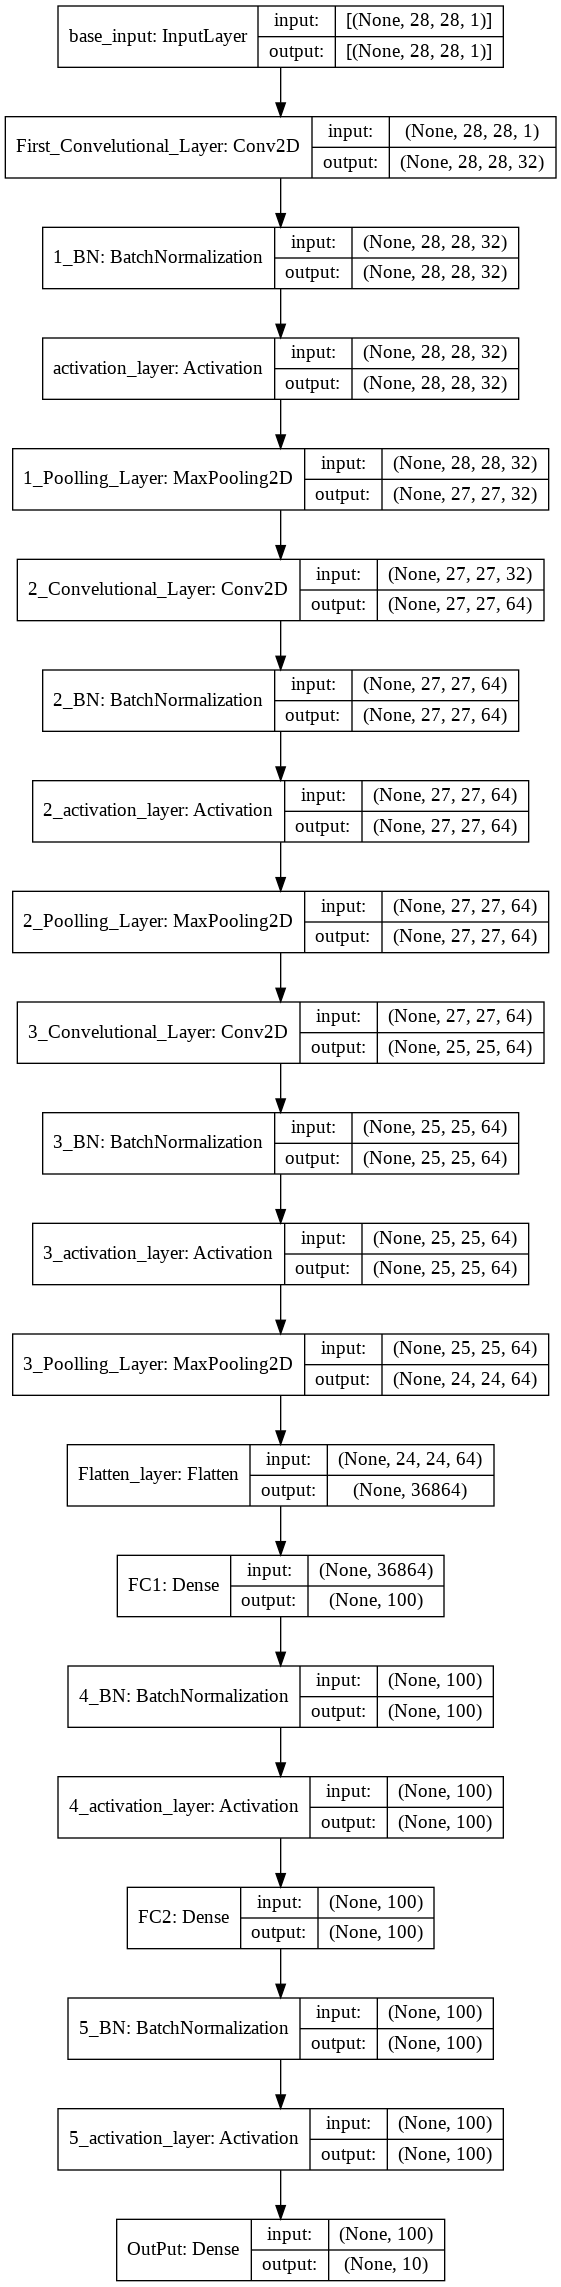

In [42]:
model= regularized_BCNN()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [43]:
scores, history,Validation_Loss =Model_Evalution(train_images,trian_labels, 
                                                 ModelName=regularized_BCNN,
                                                 K_Fold=5,epoch=10, batch_size=32)

375/375 [==============================] - 1s 3ms/step - loss: 0.2070 - accuracy: 0.9296 - MSE: 0.0104


## Model Evalution

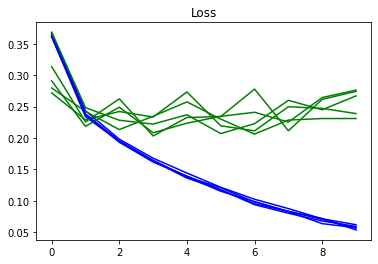

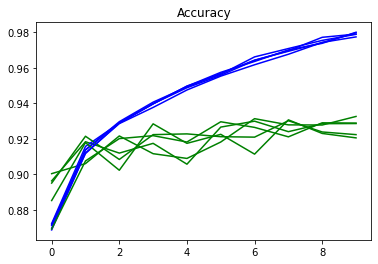

In [44]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

In [45]:
fold, bestmodel=Best_Model(scores)
PerMBCNN=MGP(test_images, test_labels,K_Fold=fold) 

313/313 [==============================] - 1s 3ms/step - loss: 0.2554 - accuracy: 0.9278 - MSE: 0.0114


## Using Dropout Layer


In [46]:
def Drop_BCNN():
    input = Input(shape=(28,28,1),name='base_input')

    ################################### 1th convoltional layer##################################
    Conv_layer1 = Conv2D(32,3,strides=(1,1),activation='relu',
                         padding='same',
                         kernel_initializer='he_uniform',
                         name='First_Convelutional_Layer')(input)

    Dropout1 = Dropout(rate=0.1,name='1_Dropout')(Conv_layer1)

    MaxPoolLayer1 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='1_Poolling_Layer')(Dropout1)

    ############################### 2th convolutional layer######################################
    Conv_layer2 = Conv2D(64,3,strides=(1,1), activation= 'relu',
                         padding='same',
                         name='2_Convelutional_Layer')(MaxPoolLayer1)
    
    Dropout2 = Dropout(rate=0.1,name='2_Dropout')(Conv_layer2)

    MaxPoolLayer2 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='2_Poolling_Layer')(Dropout2)

    ############################### 3th convolutional layer######################################
    Conv_layer3 = Conv2D(64,3,strides=(1,1), activation='relu',
                         padding='same',
                         name='3_Convelutional_Layer')(MaxPoolLayer2)

    Dropout3 = Dropout(rate=0.1,name='3_Dropout')(Conv_layer3)

    MaxPoolLayer3 = MaxPool2D(pool_size=2,strides=(1,1),
                              padding='same',
                              name='3_Poolling_Layer')(Dropout3)
    ###############################  Fully Conceted Layers ######################################
    FlattenLayer1= Flatten(name='Flatten_layer')(MaxPoolLayer3)
    
    Dense1 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC1')(FlattenLayer1)

    Dropout4 = Dropout(rate=0.1,name='4_Dropout')(Dense1)

    Dense2 =Dense(100,activation='relu',
                  kernel_initializer='he_uniform',
                  name='FC2')(Dropout4)


    OutPut= Dense(10,activation='softmax', name='OutPut')(Dense2)

    ###############################       model           ######################################
    model = Model(inputs=input,outputs=OutPut)

    

    return model

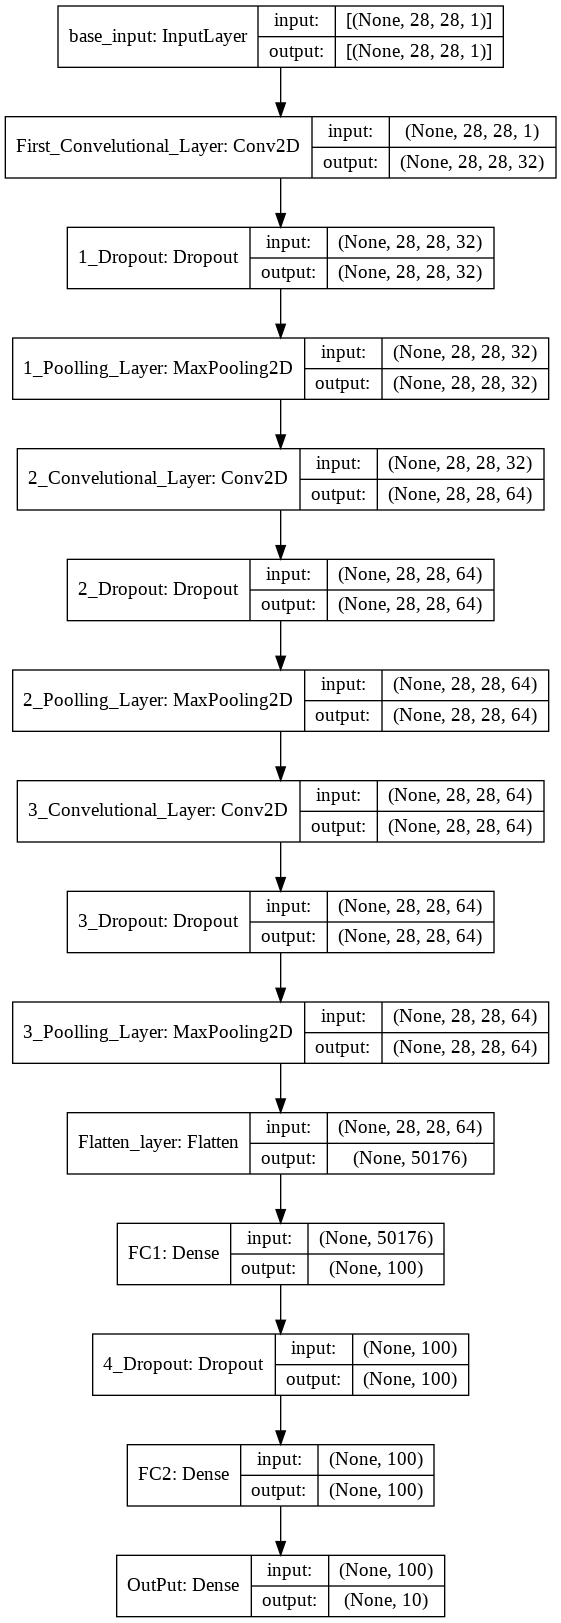

In [47]:
model= Drop_BCNN()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [48]:
scores, history,Validation_Loss =Model_Evalution(train_images,trian_labels, 
                                                 ModelName=Drop_BCNN,
                                                 K_Fold=5,epoch=10,
                                                 batch_size=32)

375/375 [==============================] - 1s 3ms/step - loss: 0.2384 - accuracy: 0.9207 - MSE: 0.0116


## Model Evalution

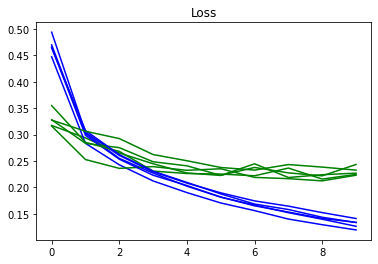

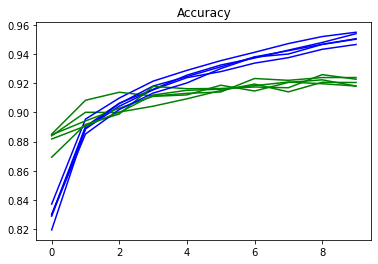

In [49]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.95,ylim=1)

In [50]:
fold, bestmodel=Best_Model(scores)
PerMBCNN=MGP(test_images, test_labels,K_Fold=fold) 

313/313 [==============================] - 1s 3ms/step - loss: 0.2295 - accuracy: 0.9226 - MSE: 0.0114


<h1> Conclusion</h1>

<hr>


<table  align="center" id="t01"> 
    <tr align="center">
        <th>   </th>
        <th> Baseline Convolutional neural network </th>
        <th>Using different padding pattern</th>
        <th> Using more convolutional layers </th>
        <th> Using batch normalize layer </th>
        <th> Using dropout layer </th>
    </tr>
    <tr align="center">
        <td> <b> Accuracy </b>  </td>
        <td> 0.8997 </td>
        <td> 0.9064</td>
        <td> 0.9132 </td>
        <td> 0.9300 </td>
        <td> 0.9220 </td>
    </tr>
     <tr align="center">
        <td> <b> Loss </b>  </td>
        <td> 0.3426 </td>
        <td> 0.2772</td>
        <td> 0.2410 </td>
        <td> 0.2390 </td>
        <td> 0.2226 </td>
    </tr>
    <tr align="center">
        <td> <b> MSE </b>  </td>
        <td> 0.0153 </td>
        <td> 0.0137</td>
        <td> 0.0123 </td>
        <td> 0.0108 </td>
        <td> 0.0116 </td>
    </tr>
    
</table>
<p align='justify'> 
as are illustrated in the above table, using batch normalization layers lead to a more efficient model which has gotten the best accuracy and minimum square error (MSE). But, as shown in the above table the minimum loss belongs to the model that has used dropout layers in order to regularize the convolutional neural network (CNN). so, using batch normalization for normalization of the input of hidden layers seems reasonable for improving the performance of a deep neural network.
</p>
<hr>

# Part 5: Using Keras Tuner in order to find the most appropriate values for the hyperparameter. 

In the following, we are going to create a function that will create a model that went to be trained with the fashion MNIST datast. 




In [51]:
def Initial_Model(hp):

    k.reset_uids()

    ########################## hyperparameter #################################
    NumFilter1 = 32; KerSize1 =3; NumFilter2 =32; KerSize2 = 3; ConvLayers=2
    NumHidLayers =2; Units1=75; 
    lr=0.001; mom=0.7


    if hp:

        NumFilter1 =hp.Choice('NumFilter1', values=[32,64])
        KerSize1 = hp.Choice('KerSize1', values=[3,5])
        NumFilter2= hp.Choice('NumFilter2', values=[32,64])
        KerSize2 = hp.Choice('KerSize2', values=[3,5,7])
        ConvLayers = hp.Choice('ConvLayers', values=[2,3,4])

        NumHidLayers=hp.Choice('NumHidLayers',values=range(1,6))
        Units1 = hp.Choice('Units1', values=range(80,130,10))

        lr =hp.Float('lr',min_value=0.001, max_value=0.01)
        mom =hp.Float('mom',min_value=0.7, max_value=1)

    #############################Input Layer###################################
    # Input layer 

    inputs = Input(shape=(28,28,1),name='Input')
    ##########################Convolutional Layers##############################
    #convolutional layers 
    ConvLayer1 = Conv2D(NumFilter1, KerSize1,strides=(1,1),
                        padding='same')(inputs)

    BN1 = BatchNormalization()(ConvLayer1)

    Activ1= Activation('relu')(BN1)

    x= MaxPool2D(pool_size=(2,2),
                 strides=(1,1),
                 padding='valid')(Activ1)

    for i in range(1,ConvLayers):

        x = Conv2D(NumFilter1, KerSize1,strides=(1,1),
                            padding='same')(x)

        x = BatchNormalization()(x)

        x= Activation('relu')(x)

        x= MaxPool2D(pool_size=(2,2),
                    strides=(1,1),
                    padding='valid')(x)
    


    
    ##########################Fully Conected Layers#############################

    x = Flatten(name='Flatten')(x)

    

    for i in range(1,NumHidLayers+1):
        x = Dense(Units1)(x)
        x=BatchNormalization()(x)
        x= Activation('relu')(x)

    out = Dense(10,activation='softmax',name='output')(x)

    model = Model(inputs=inputs,outputs=out)

    sgd = SGD(learning_rate=lr,momentum=mom)

    model.compile(loss='CategoricalCrossentropy',optimizer=sgd,
            metrics=[
                    
                    'accuracy',
                    'MSE'
            ])
        
    return model

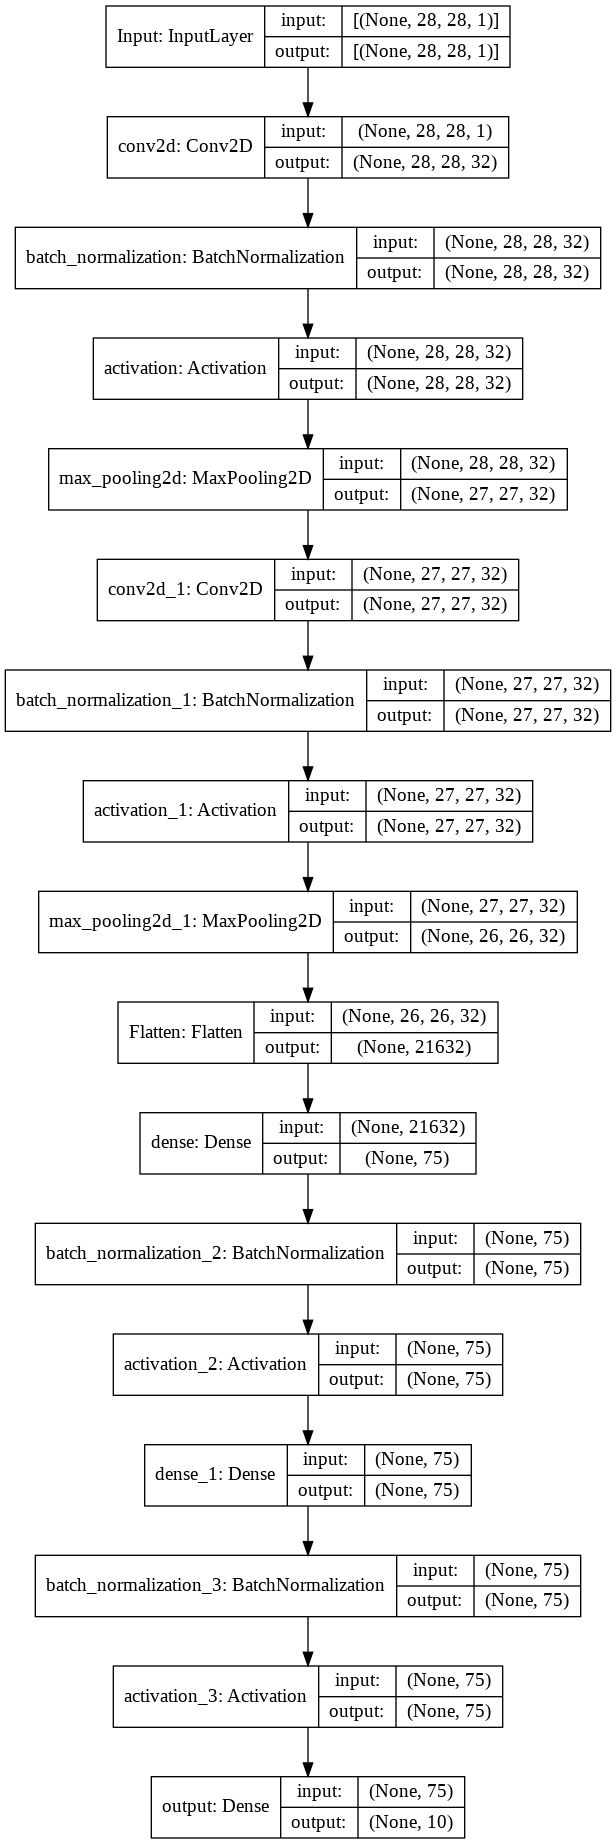

In [52]:
model= Initial_Model(None)
plot_model(model,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128   

## Creating a tuner

in this part, a class for creating a tuner is defined. this class uses BayesianOptimization to find the best hyperparameter for our model. Notice that we can use kerastuner.tuners directly for tuning the hyperparameters of the Initial_Model function. but, here, we have considered another hyperparameter namely 'batch_size', so we needed to define a custom tuner.  

In [54]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial,*args,**kwargs):
        kwargs['batch_size']= trial.hyperparameters.Int('batch_size',32,128,step=32)
        super(CustomTuner,self).run_trial(trial,*args,**kwargs)


## creating an instance of our custom tuner

In [55]:

tuner = CustomTuner(
    Initial_Model,
    objective='val_accuracy',
    max_trials=10,
    directory='logs',
    project_name='Keras_tuner',
    overwrite=True,
    )

<h1> Print search sapce summary</h1>

In [56]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
NumFilter1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
KerSize1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
NumFilter2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
KerSize2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
ConvLayers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
NumHidLayers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3, 4, 5], 'ordered': True}
Units1 (Choice)
{'default': 80, 'conditions': [], 'values': [80, 90, 100, 110, 120], 'ordered': True}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': None}
mom (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 1.0, 'step': None, 'sampling': None}


<h1> Performs a search for the best hyperparameter configurations. </h1>

In [57]:
 # Creat Callbacks 

TuneHistory= tuner.search(
    train_images,trian_labels,
    validation_split=0.1,
    epochs=10,verbose=False
)

INFO:tensorflow:Oracle triggered exit


## Results

The following results obtiend after running our tuner

In [58]:
# Show a summary of the search
tuner.results_summary(num_trials=1)

Results summary
Results in logs/Keras_tuner
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
NumFilter1: 32
KerSize1: 3
NumFilter2: 64
KerSize2: 5
ConvLayers: 4
NumHidLayers: 2
Units1: 110
lr: 0.009304864893496266
mom: 0.7359288214841325
batch_size: 32
Score: 0.9308333396911621


In [59]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [60]:
# Evaluate the best model.
loss, accuracy,mse = best_model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.2204 - accuracy: 0.9260 - MSE: 0.0111


## Conclusion part

as observed above, the best results are obtained by the model that uses all data for training. so, it seems reasonable that using data augmentation lead to a better result. 